#Image Recolouring Project

Project developed by Alejandro Cano Caldero and Jesús Moncada Ramírez for the subject Neural Networks and Deep Learning, University of Padova, 2022-23.


In [4]:
!pip install lpips

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 2.9 MB/s eta 0:00:00


In [5]:
!pip install torchmetrics[image]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 10.0 MB/s eta 0:00:00


In [81]:
# Import necessary libraries for our project.
import numpy as np

import torch

import matplotlib.pyplot as plt

from torchvision import transforms, datasets
from torchvision.transforms import transforms

from torch.utils.data import DataLoader, Dataset  

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as op

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

from torch import autograd

In [37]:
# Define the execution device.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
# Mount in Google Drive. 
# Only execute if running in Google Colab and the dataset is on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1. Creating our dataset

For the dataset we have used [ImageNette](https://github.com/fastai/imagenette), a reduced version of ImageNet, specifically the full size images version.

<code>ImageDataset</code> is a default dataset class for images . To create an instance of this class you have to specify the route of the image folder (<code>image_path</code>) and a list of transforms (<code>transforms</code>). Basically it is an adapted version of <code>torchvision.datasets.ImageFolder</code>. Note that only returns one image when accessing to an element in <code>\_\_getitem\_\_</code>.

In [39]:
class ImageDataset(Dataset):
  def __init__(self, image_path, transform=None):
    super(ImageDataset, self).__init__()
    self.data = datasets.ImageFolder(image_path,  transform)

  def __getitem__(self, idx):
    x, y = self.data[idx]
    return x

  def __len__(self):
    return len(self.data)

<code>TwoImagesDataset</code> is a dataset class combining two images datasets. In this case it returns two versions of the same image when accessing to an element, the first one is the grayscale version (input image) and the second one is the colored version (target image).

In [42]:
class TwoImagesDataset(Dataset):
  def __init__(self, dataset1, dataset2):
    super(TwoImagesDataset, self).__init__()
    self.dataset1 = dataset1
    self.dataset2 = dataset2
    if len(self.dataset1) != len(self.dataset2):
      print('ERROR, len of dataset1 is different from len of dataset2')

  def __getitem__(self, idx):
    return self.dataset1[idx], self.dataset2[idx]

  def __len__(self):
    return 10
    # return len(self.dataset1)

After defining the data structures, we will create a dataset class with all the images resized to <code>256 x 256</code> (<code>colored_data</code>), after we will create a dataset class with all the images resized to <code>256 x 256</code> in grayscale (<code>grayscale_data</code>). By last we will create the dataset class containing both kind of images (<code>dataset</code>).

In [43]:
# If locating the dataset in Google Drive
img_path = 'drive/MyDrive/imagenette2/train'

# Define normalization [0, 255] --> [-1, 1] (Owing to the use of the tanh activation function)

colored_transform = transforms.Compose(
    [transforms.ToTensor(), # to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalization [0, 255] --> [-1, 1] (to the tanh activation function)
     transforms.Resize((256, 256)) # resize to (256, 256)
     ] )

grayscale_transform = transforms.Compose(
    [transforms.ToTensor(), # to tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalization [0, 255] --> [-1, 1] (to the tanh activation function)
     transforms.Resize((256, 256)), # resize to (256, 256)
     transforms.Grayscale(3) # to grayscale
     ])

colored_data = ImageDataset(img_path, colored_transform)
grayscale_data = ImageDataset(img_path, grayscale_transform)
dataset = TwoImagesDataset(grayscale_data, colored_data)

In [44]:
print("Number of images in our dataset is: {0}".format(len(dataset)))

Number of images in our dataset is: 10


To check everything was ok let's show (with a function <code>plot_image</code>)the colored and the grayscale version of the same image.

Plotting a color image in the dataset:


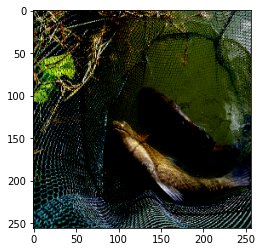

In [45]:
def plot_image(img):
  plt.imshow(img.permute(1, 2, 0))

print('Plotting a color image in the dataset:')
plot_image(colored_data[0])

Plotting a grayscale image in the dataset:


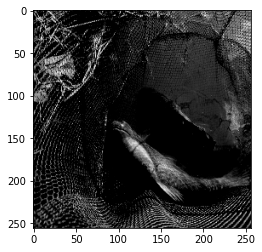

In [46]:
print('Plotting a grayscale image in the dataset:')
plot_image(grayscale_data[0])

We will also create a function to show images where each element takes value from -1 to 1, <code>plot_image_minus1to1</code>.

In [47]:
def plot_image_minus1to1(image):
  plot_image((image + 1) / 2)

We will also create a data loader instance for our dataset in order to get the images as batchs for the training phase. The batch size will be 1 as said in the paper.

In [48]:
dataloader = DataLoader(dataset, batch_size=1)

##2. Discriminator

The discriminator used (called PatchGAN) takes as input an image of <code>(256x256)</code> and returns a tensor of <code>(30x30)</code>. The discriminator class is the following:

In [49]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1):
        super().__init__()
        
        self.layer1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2 = nn.Conv2d(64, out_channels=128, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2_bn = nn.BatchNorm2d(128)
        self.layer3 = nn.Conv2d(128, out_channels=256, kernel_size=kernel_size, stride=2, padding=1)
        self.layer3_bn = nn.BatchNorm2d(256)
        self.layer4 = nn.Conv2d(256, out_channels=512, kernel_size=kernel_size, padding=1) # stride = 1
        self.layer4_bn = nn.BatchNorm2d(512)
        self.layer5 = nn.Conv2d(512, out_channels=1, kernel_size=kernel_size, padding=1)
        
        # Weight initialization
        torch.nn.init.normal_(self.layer1.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer3.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer4.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer5.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer2_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer3_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer3_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer4_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer4_bn.bias.data, 0.0)

    def forward(self, x, verbose=False):
        d = F.leaky_relu(self.layer1(x), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer2_bn(self.layer2(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer3_bn(self.layer3(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer4_bn(self.layer4(d)), 0.2)
        if verbose:
          print(d.shape)
        d = self.layer5(d)
        if verbose:
          print(d.shape)

        return torch.sigmoid(d)

Let's create an object for the discriminator, and its Adam optimizer.

In [50]:
discriminator = Discriminator(in_channels=6, kernel_size=4)
discriminator.to(device)

discriminator_optimizer = op.Adam(discriminator.parameters(), lr=0.0002, weight_decay=0.5)

And let's execute the discriminator forward pass on a pair of images concatenated from dataset to check if it works.

In [51]:
input_img, target_img = dataset[0]

input_img = input_img.unsqueeze(0)
target_img = target_img.unsqueeze(0)
# unsqueeze(0) needed to get batch_size = 1

disc_input = torch.cat((input_img, target_img), dim=1) # discriminator input
print("Dimension of image passed as argument: {0}".format(disc_input.shape))

res = discriminator.forward(disc_input) # forward pass discriminator

print("Dimension of discriminator output: {0}".format(res.shape))

Dimension of image passed as argument: torch.Size([1, 6, 256, 256])
Dimension of discriminator output: torch.Size([1, 1, 30, 30])


##3. Generator

The generator used has an autoencoder style, with both encoder and decoder networks. The input and the output are images. It uses a UNET Generator, with skip connections.The generator class is the following:

In [52]:
class Generator(nn.Module):
  def __init__(self, in_channels, stride=1):
    super().__init__()

    # ----------------------------- ENCODER ----------------------------
    #            ENCODER MODEL: C64-C128-C256-C512-C512-C512-C512
    self.layer1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.layer2 = nn.Conv2d(64, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.layer2_bn = nn.BatchNorm2d(128)
    self.layer3 = nn.Conv2d(128, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.layer3_bn = nn.BatchNorm2d(256)
    self.layer4 = nn.Conv2d(256, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer4_bn = nn.BatchNorm2d(512)
    self.layer5 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer5_bn = nn.BatchNorm2d(512)
    self.layer6 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer6_bn = nn.BatchNorm2d(512)
    self.layer7 = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer7_bn = nn.BatchNorm2d(512)
    # ----------------------------- /ENCODER ----------------------------


    # ----------------------------- BOTTLENECK ----------------------------
    self.bottleneck_layer = nn.Conv2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    # ----------------------------- /BOTTLENECK ----------------------------


    # ----------------------------- DECODER ----------------------------
    #           DECODER MODEL: CD512-CD512-CD512-CD512-CD256-CD128-CD64
    self.layer8 = nn.ConvTranspose2d(512, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer8_bn = nn.BatchNorm2d(512)
    self.layer8_dpout = nn.Dropout()
    self.layer9 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer9_bn = nn.BatchNorm2d(512)
    self.layer9_dpout = nn.Dropout()
    self.layer10 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer10_bn = nn.BatchNorm2d(512)
    self.layer10_dpout = nn.Dropout()
    self.layer11 = nn.ConvTranspose2d(1024, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.layer11_bn = nn.BatchNorm2d(512)
    self.layer12 = nn.ConvTranspose2d(1024, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.layer12_bn = nn.BatchNorm2d(256)
    self.layer13 = nn.ConvTranspose2d(512, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.layer13_bn = nn.BatchNorm2d(128)
    self.layer14 = nn.ConvTranspose2d(256, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.layer14_bn = nn.BatchNorm2d(64)
    # ----------------------------- /DECODER ----------------------------

    # ----------------------------- OUTPUT ----------------------------
    self.layer15 = nn.ConvTranspose2d(128, out_channels=3, kernel_size=4, stride=2, padding=1)

    # Weight initialization
    torch.nn.init.normal_(self.layer1.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer2.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer3.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer4.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer5.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer6.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer7.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.bottleneck_layer.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer8.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer9.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer10.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer11.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer12.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer13.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer14.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer15.weight.data, mean=0.0, std=0.02)
    torch.nn.init.normal_(self.layer2_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer2_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer3_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer3_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer4_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer4_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer5_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer5_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer6_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer6_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer7_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer7_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer8_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer8_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer9_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer9_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer10_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer10_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer11_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer11_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer12_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer12_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer13_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer13_bn.bias.data, 0.0)
    torch.nn.init.normal_(self.layer14_bn.weight.data, mean=1.0, std=0.02)
    torch.nn.init.constant_(self.layer14_bn.bias.data, 0.0)

  def forward(self, x, verbose=False):

    # ----------------------------- ENCODER ----------------------------
    e1 = F.leaky_relu(self.layer1(x), 0.2)
    if verbose:
      print(e1.shape)
    e2 = F.leaky_relu(self.layer2_bn(self.layer2(e1)), 0.2)
    if verbose:
      print(e2.shape)
    e3 = F.leaky_relu(self.layer3_bn(self.layer3(e2)), 0.2)
    if verbose:
      print(e3.shape)
    e4 = F.leaky_relu(self.layer4_bn(self.layer4(e3)), 0.2)
    if verbose:
      print(e4.shape)
    e5 = F.leaky_relu(self.layer5_bn(self.layer5(e4)), 0.2)
    if verbose:
      print(e5.shape)
    e6 = F.leaky_relu(self.layer6_bn(self.layer6(e5)), 0.2)
    if verbose:
      print(e6.shape)
    e7 = F.leaky_relu(self.layer7_bn(self.layer7(e6)), 0.2) 
    if verbose:
      print(e7.shape)
    # ----------------------------- /ENCODER ----------------------------


    # ----------------------------- BOTTLENECK ----------------------------
    b = F.relu(self.bottleneck_layer(e7))
    if verbose:
      print(b.shape)

    # ----------------------------- DECODER ----------------------------
    d1 = F.relu(torch.cat((self.layer8_dpout(self.layer8_bn(self.layer8(b))), e7), 1))
    if verbose:
      print(d1.shape)
    d2 = F.relu(torch.cat((self.layer9_dpout(self.layer9_bn(self.layer9(d1))), e6), 1))
    if verbose:
      print(d2.shape)
    d3 = F.relu(torch.cat((self.layer10_dpout(self.layer10_bn(self.layer10(d2))), e5), 1))
    if verbose:
      print(d3.shape)
    d4 = F.relu(torch.cat(((self.layer11_bn(self.layer11(d3))), e4), 1))
    if verbose:
      print(d4.shape)
    d5 = F.relu(torch.cat(((self.layer12_bn(self.layer12(d4))), e3), 1))
    if verbose:
      print(d5.shape)
    d6 = F.relu(torch.cat(((self.layer13_bn(self.layer13(d5))), e2), 1))
    if verbose:
      print(d6.shape)
    d7 = F.relu(torch.cat(((self.layer14_bn(self.layer14(d6))), e1), 1))
    if verbose:
      print(d7.shape)

    # ----------------------------- OUTPUT ----------------------------
    o = torch.tanh(self.layer15(d7))

    return o

In [53]:
generator = Generator(3)
generator.to(device)

generator_optimizer = op.Adam(generator.parameters(), lr=0.0002, weight_decay=0.5)

Input shape torch.Size([1, 3, 256, 256])
Output shape:  torch.Size([1, 3, 256, 256])


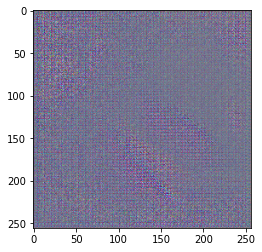

In [57]:
input_img, tg_img = dataset[0]

input = input_img.unsqueeze(0)
print("Input shape {0}".format(input.shape))

out = generator.forward(input)
print("Output shape: ", out.shape)

out = out.detach()
plot_image_minus1to1(out[0])

##4. Loss function

For the loss function, we are going to use the **Binary Cross-Entropy** loss

In [58]:
adversarial_loss = nn.BCELoss(weight=torch.tensor(0.5))
l1_loss = nn.L1Loss()

Four parameters are fed to the generator_loss function:



1. **generator_image:** Images produced by the generator
2. **target_image:** Ground-truth pair image for the input fed to the generator.
3. **discriminator_predictions**: Output predictions from the discriminator, when fed with generator-produced images.
4. **real_target:** Ground-truth labels (1), as you would like the generator to produce real images by fooling the discriminator. The labels therefore would be one.

In [59]:
def generator_loss(generator_image, target_image, discriminator_predictions, real_target):
  gen_loss = adversarial_loss(discriminator_predictions, real_target)
  l1_l = l1_loss(generator_image, target_image)
  result = gen_loss + (100 * l1_l)

  return result

The discriminator loss has:

1. The real (original images) output predictions ground-truth label as 1
2. Fake (generated images) output predictions ground-truth label as 0.

In [60]:
def discriminator_loss(output, label):
  return adversarial_loss(output, label)

##5. Training

In [61]:
num_epochs = 1
cnt = 1

for epoch in range(1, num_epochs + 1):
  for (input_img, tg_img) in dataloader:

    discriminator_optimizer.zero_grad()
    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    # ground truth labels real and fake
    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    # generator forward pass
    generated_image = generator(input_img)

    # train discriminator with fake/generated images
    disc_inp_fake = torch.cat((input_img, generated_image), 1)

    discriminator_fake = discriminator(disc_inp_fake.detach())

    discriminator_fake_loss = discriminator_loss(discriminator_fake, fake_target)

    # train discriminator with real images
    disc_inp_real = torch.cat((input_img, target_img), 1)

    discriminator_real = discriminator(disc_inp_real)
    discriminator_real_loss = discriminator_loss(discriminator_real,  real_target)


    # average discriminator loss
    discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

    # compute gradients and run optimizer step
    discriminator_total_loss.backward()
    discriminator_optimizer.step()

    # Train generator with real labels
    generator_optimizer.zero_grad()
    fake_gen = torch.cat((input_img, generated_image), 1)
    discriminator_prediction = discriminator(fake_gen)
    gen_loss = generator_loss(generated_image, tg_img, discriminator_prediction, real_target)                              

    # compute gradients and run optimizer step
    gen_loss.backward()
    generator_optimizer.step()

    if cnt % 10 == 0:
      print("Number of processed batches (batch_size = 1): ", cnt)

    cnt = cnt + 1

Number of processed batches (batch_size = 1):  10


Generated image:


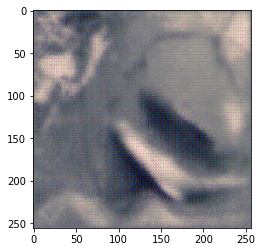

In [63]:
# TEST
input_img, tg_img = dataset[0]
out = generator.forward(input_img.unsqueeze(0))

out = out.detach()

print('Generated image:')
plot_image_minus1to1(out[0])

Input image:


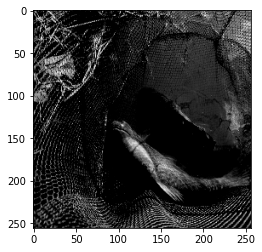

In [65]:
print('Input image:')
plot_image(input_img)

Now, we **save** the models. That way, we do not need to retrain them. What we are actually doing is storing a map that contains all the layers and their corresponding parameters. 

In [67]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

generator_model_path = "drive/MyDrive/models/generatorModelImageColoring.pth"
discriminator_model_path = "drive/MyDrive/models/discriminatorModelImageColoring.pth"

save_model(generator, generator_model_path)
save_model(discriminator, discriminator_model_path)

So as to retrive the models:

In [68]:
def load_model(model, path):
  return model.load_state_dict(torch.load(path))

generator = Generator(3)
load_model(generator, generator_model_path)

discriminator = Discriminator(in_channels=6, kernel_size=4)
load_model(discriminator, discriminator_model_path)

<All keys matched successfully>

##6. Using additional perceptual losses (torchmetrics)


The first improvement we have implemented, <code>LearnedPerceptualImagePatchSimilarity</code>, is used to judge the perceptual similarity between two images.

In [69]:
lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex')

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

This way, we have to define a new generator loss.

In [70]:
def generator_loss_lpips(generator_image, target_image, discriminator_predictions, real_target):
  gen_loss = adversarial_loss(discriminator_predictions, real_target)
  l1_l = l1_loss(generator_image, target_image)
  perceptual_similarity = lpips(generator_image, target_image)
  result = gen_loss + (100 * l1_l) + perceptual_similarity

  return result

In [71]:
generator_lpips = Generator(3)
generator_lpips.to(device)
generator_optimizer_lpips = op.Adam(generator_lpips.parameters(), lr=0.0002, weight_decay=0.5)

discriminator_lpips = Discriminator(in_channels=6, kernel_size=4)
discriminator_lpips.to(device)
discriminator_optimizer_lpips = op.Adam(discriminator_lpips.parameters(), lr=0.0002, weight_decay=0.5)

Therefore, the training phase would follow as:

In [72]:
num_epochs = 1
cnt = 1

for epoch in range(1, num_epochs + 1):
  for (input_img, tg_img) in dataloader:

    discriminator_optimizer_lpips.zero_grad()
    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    # ground truth labels real and fake
    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    # generator forward pass
    generated_image = generator_lpips(input_img)

    # train discriminator with fake/generated images
    disc_inp_fake = torch.cat((input_img, generated_image), 1)

    discriminator_fake = discriminator_lpips(disc_inp_fake.detach())

    discriminator_fake_loss = discriminator_loss(discriminator_fake, fake_target)

    # train discriminator with real images
    disc_inp_real = torch.cat((input_img, target_img), 1)

    discriminator_real = discriminator_lpips(disc_inp_real)
    discriminator_real_loss = discriminator_loss(discriminator_real,  real_target)

    # average discriminator loss
    discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

    # compute gradients and run optimizer step
    discriminator_total_loss.backward()
    discriminator_optimizer_lpips.step()

    # Train generator with real labels
    generator_optimizer_lpips.zero_grad()
    fake_gen = torch.cat((input_img, generated_image), 1)
    discriminator_prediction = discriminator_lpips(fake_gen)
    # The generator loss has changed
    gen_loss = generator_loss_lpips(generated_image, tg_img, discriminator_prediction, real_target)                              

    # compute gradients and run optimizer step
    gen_loss.backward()
    generator_optimizer_lpips.step()

    if cnt % 10 == 0:
      print("Number of processed batches (batch_size = 1): ", cnt)
    
    cnt = cnt + 1

Number of processed batches (batch_size = 1):  10


Generated image:


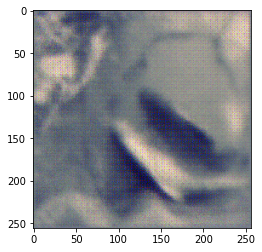

In [73]:
# TEST
input_img, tg_img = dataset[0]
out = generator_lpips.forward(input_img.unsqueeze(0))

out = out.detach()

print('Generated image:')
plot_image_minus1to1(out[0])

Now let's save the new models obtained.

In [75]:
generator_model_lpips_path = "drive/MyDrive/models/generatorModelImageColoringLpips.pth"
discriminator_model_lpips_path = "drive/MyDrive/models/discriminatorModelImageColoringLpips.pth"

save_model(generator_lpips, generator_model_lpips_path)
save_model(discriminator_lpips, discriminator_model_lpips_path)

##7. Using WGAN as training mechanism


In [87]:
class DiscriminatorWGAN(nn.Module):
    def __init__(self, in_channels, kernel_size, stride=1):
        super().__init__()
        
        self.layer1 = nn.Conv2d(in_channels, out_channels=64, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2 = nn.Conv2d(64, out_channels=128, kernel_size=kernel_size, stride=2, padding=1)
        self.layer2_bn = nn.BatchNorm2d(128)
        self.layer3 = nn.Conv2d(128, out_channels=256, kernel_size=kernel_size, stride=2, padding=1)
        self.layer3_bn = nn.BatchNorm2d(256)
        self.layer4 = nn.Conv2d(256, out_channels=512, kernel_size=kernel_size, padding=1) # stride = 1
        self.layer4_bn = nn.BatchNorm2d(512)
        self.layer5 = nn.Conv2d(512, out_channels=1, kernel_size=kernel_size, padding=1)
        
        # Weight initialization
        torch.nn.init.normal_(self.layer1.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer3.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer4.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer5.weight.data, mean=0.0, std=0.02)
        torch.nn.init.normal_(self.layer2_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer2_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer3_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer3_bn.bias.data, 0.0)
        torch.nn.init.normal_(self.layer4_bn.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(self.layer4_bn.bias.data, 0.0)

    def forward(self, x, verbose=False):
        d = F.leaky_relu(self.layer1(x), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer2_bn(self.layer2(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer3_bn(self.layer3(d)), 0.2)
        if verbose:
          print(d.shape)
        d = F.leaky_relu(self.layer4_bn(self.layer4(d)), 0.2)
        if verbose:
          print(d.shape)
        d = self.layer5(d)
        if verbose:
          print(d.shape)

        # The activation function has disappeared
        return torch.sigmoid(d)

In [88]:
generator_wgan = Generator(3)
generator_wgan.to(device)
generator_optimizer_wgan = op.Adam(generator_wgan.parameters(), lr=0.0002, weight_decay=0.5)

discriminator_wgan = DiscriminatorWGAN(in_channels=6, kernel_size=4)
discriminator_wgan.to(device)
discriminator_optimizer_wgan = op.Adam(discriminator_wgan.parameters(), lr=0.0002, weight_decay=0.5)

In [89]:
def compute_gp(discriminator, real_data, fake_data):
  
  batch_size = real_data.size(0)
  
  # Sample Epsilon from uniform distribution
  eps = torch.rand(batch_size, 1, 1, 1).to(real_data.device)
  eps = eps.expand_as(real_data)
        
  # Interpolation between real data and fake data.
  interpolation = eps * real_data + (1 - eps) * fake_data
        
  # get logits for interpolated images
  interp_logits = discriminator(interpolation)
  grad_outputs = torch.ones_like(interp_logits)
        
  # Compute Gradients
  gradients = autograd.grad(
    outputs=interp_logits,
    inputs=interpolation,
    grad_outputs=grad_outputs,
    create_graph=True,
    retain_graph=True,
  )[0]
        
  # Compute and return Gradient Norm
  gradients = gradients.view(batch_size, -1)
  grad_norm = gradients.norm(2, 1)
  return torch.mean((grad_norm - 1) ** 2)

In [90]:
def discriminator_loss_wgan(output, label, gradient_penalty, c_lambda=10):
  return torch.mean(output - label  + gradient_penalty * c_lambda)

In [91]:
num_epochs = 1
cnt = 1

for epoch in range(1, num_epochs + 1):
  for (input_img, tg_img) in dataloader:

    discriminator_optimizer_wgan.zero_grad()

    input_img = input_img.to(device)
    tg_img = tg_img.to(device)

    # ground truth labels real and fake
    real_target = torch.ones(input_img.size(0), 1, 30, 30).to(device)
    fake_target = torch.zeros(input_img.size(0), 1, 30, 30).to(device)

    # generator forward pass
    generated_image = generator_wgan(input_img)


    # train discriminator with fake/generated images
    disc_inp_fake = torch.cat((input_img, generated_image), 1)
    discriminator_fake = discriminator_wgan(disc_inp_fake.detach())
    
    # train discriminator with real images
    disc_inp_real = torch.cat((input_img, target_img), 1)
    discriminator_real = discriminator_wgan(disc_inp_real)

    # calculate gradient penalty
    gradient_penalty = compute_gp(discriminator, disc_inp_real, disc_inp_fake)

    # calculate discriminator losses
    discriminator_fake_loss = discriminator_loss_wgan(discriminator_fake, fake_target, gradient_penalty)
    discriminator_real_loss = discriminator_loss_wgan(discriminator_real,  real_target, gradient_penalty)
    
    # average discriminator loss
    discriminator_total_loss = (discriminator_real_loss + discriminator_fake_loss) / 2

    # compute gradients and run optimizer step
    discriminator_total_loss.backward()
    discriminator_optimizer_wgan.step()

    # Train generator with real labels
    generator_optimizer_wgan.zero_grad()
    fake_gen = torch.cat((input_img, generated_image), 1)
    discriminator_prediction = discriminator_wgan(fake_gen)
    # The generator loss has changed
    gen_loss = generator_loss(generated_image, tg_img, discriminator_prediction, real_target)                              

    # compute gradients and run optimizer step
    gen_loss.backward()
    generator_optimizer_wgan.step()

    if cnt % 10 == 0:
      print("Number of processed batches (batch_size = 1): ", cnt)
    
    cnt = cnt + 1

RuntimeError: ignored

In [ ]:
generator_model_wgan_path = "./models/generatorModelImageColoringWgan.pth"
discriminator_model_wgan_path = "./models/discriminatorModelImageColoringWgan.pth"

save_model(generator_wgan, generator_model_wgan_path)
save_model(discriminator_wgan, discriminator_model_wgan_path)